In [6]:
from simsopt._core import load
from simsopt.geo import CurveXYZFourier, SurfaceRZFourier
from simsopt.field import BiotSavart, Coil, load_coils_from_makegrid_file
from simsopt.mhd import Vmec
import matplotlib.pyplot as plt

import numpy as np

%matplotlib widget

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.landreman_paul_qa_scaled
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Feb 05,2024  TIME = 16:12:36
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.landreman_paul_qa_scaled
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Feb 05,2024  TIME = 16:12:36
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.landreman_paul_qa_scaled

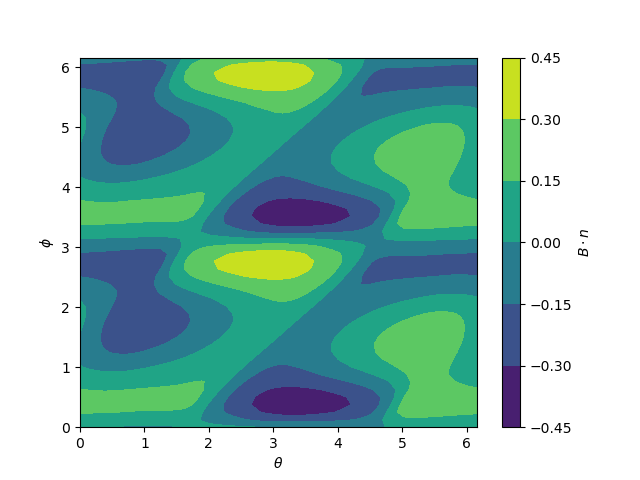

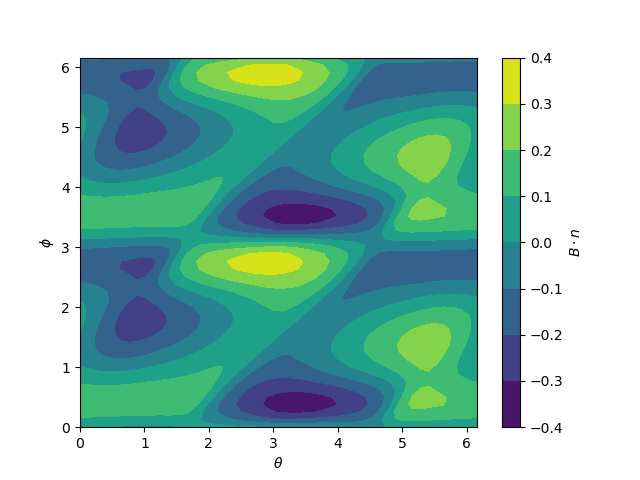

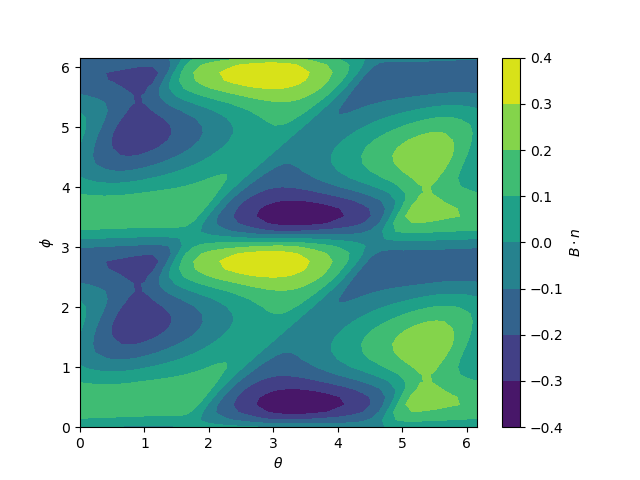

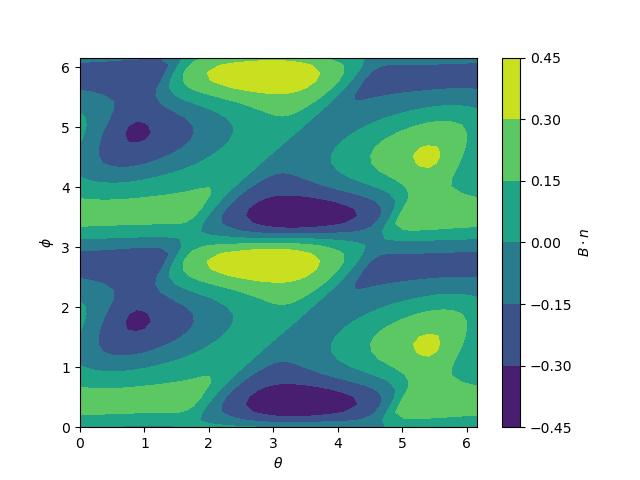

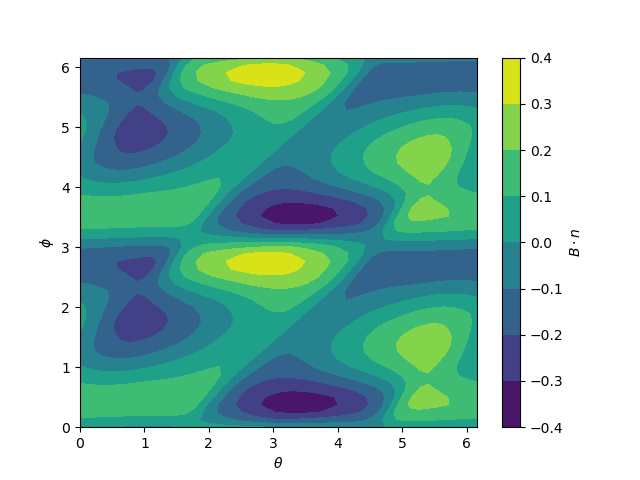

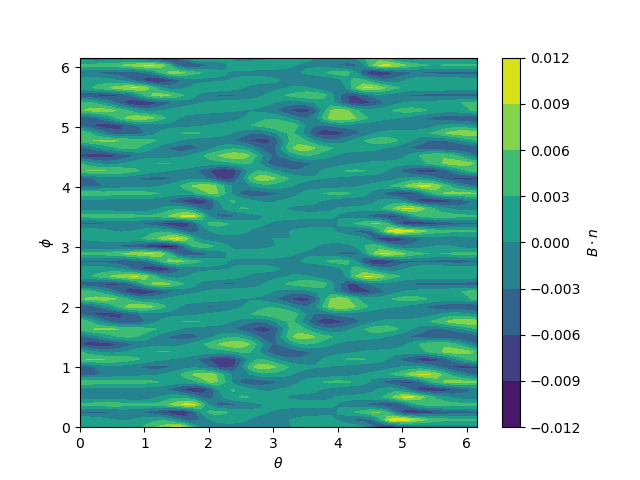

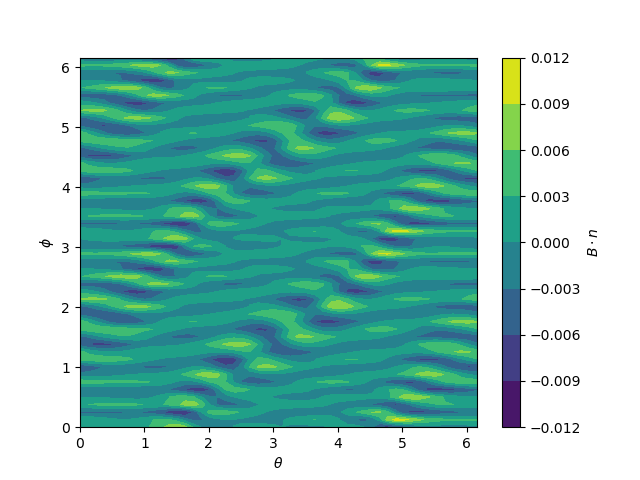

In [7]:
order = 16
quandidates = [
    'output_well_True_lengthbound_24.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_6_order_16_alstart_0_expquad_samples_4096_sigma_0.001_usedetig.nc',
    'output_well_True_lengthbound_24.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_5_order_16_alstart_0_expquad.nc',
    'output_well_True_lengthbound_22.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_7_order_16_alstart_0_expquad.nc',
    'output_well_True_lengthbound_22.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_6_order_16_alstart_0_expquad_samples_4096_sigma_0.001_usedetig.nc',
    'output_well_True_lengthbound_20.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_3_order_16_alstart_0_expquad.nc',
    'output_well_False_lengthbound_18.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_6_order_16_alstart_0_expquad_samples_4096_sigma_0.001_usedetig.nc',
    'output_well_False_lengthbound_18.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_3_order_16_alstart_0_expquad.nc'
]
for fname in quandidates:
    coils = load_coils_from_makegrid_file( fname, order )
    
    for ii, c in enumerate(coils):
        sgn = 1
        if ii>3 and ii<8:
            sgn = -1
        if ii>11:
            sgn = -1
        cur = c.current.get_value()
        c.current.set('x0', sgn*cur*1E7)
    
    for ii, c in enumerate(coils):
        curve = c.curve
        curve.x = curve.x * 9.229649839967937

    bs = BiotSavart(coils)
    v = Vmec('../input.landreman_paul_qa_scaled')
    surf = v.boundary
    bs.set_points(surf.gamma().reshape((-1,3)))

    ss = surf.gamma().shape
    theta = surf.quadpoints_theta * 2 * np.pi
    phi = surf.quadpoints_phi * 2 * np.pi
    fig, ax = plt.subplots()
    Bdotn = np.sum(bs.B().reshape(ss) * surf.unitnormal(), axis=2) 
    ax.set_ylabel(r'$\phi$')
    ax.set_xlabel(r'$\theta$')
    c = ax.contourf(theta,phi,Bdotn)
    plt.colorbar(c,label=r'$B\cdot n$')

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.landreman_paul_qa_scaled
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Feb 05,2024  TIME = 16:13:02


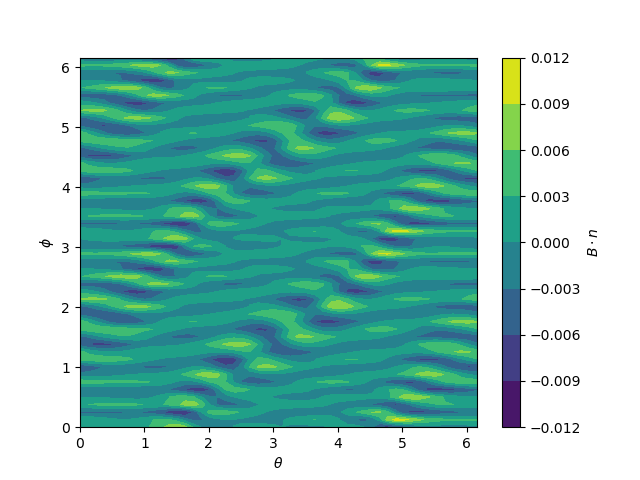

In [9]:
from simsopt.field import apply_symmetries_to_curves, apply_symmetries_to_currents, Coil

fname = quandidates[-1]
coils = load_coils_from_makegrid_file( fname, order )

ncoils = len(coils)
base_coils = coils[0:int(ncoils/4)]
base_curves = [c.curve for c in base_coils]
base_currents = [c.current for c in base_coils]

nfp = surf.nfp

for ii, c in enumerate(base_currents):
    sgn = 1
    if ii>3 and ii<8:
        sgn = -1
    if ii>11:
        sgn = -1
    cur = c.get_value()
    c.set('x0', sgn*cur*1E7)

for ii, c in enumerate(base_curves):
    c.x = c.x * 9.229649839967937

curves = apply_symmetries_to_curves( base_curves, nfp, True )
currents = apply_symmetries_to_currents( base_currents, nfp, True )
coils = [Coil(curve, current) for curve, current in zip(curves, currents)]

bs = BiotSavart(coils)
v = Vmec('../input.landreman_paul_qa_scaled')
surf = v.boundary
bs.set_points(surf.gamma().reshape((-1,3)))

ss = surf.gamma().shape
theta = surf.quadpoints_theta * 2 * np.pi
phi = surf.quadpoints_phi * 2 * np.pi
fig, ax = plt.subplots()
Bdotn = np.sum(bs.B().reshape(ss) * surf.unitnormal(), axis=2) 
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')
c = ax.contourf(theta,phi,Bdotn)
plt.colorbar(c,label=r'$B\cdot n$')

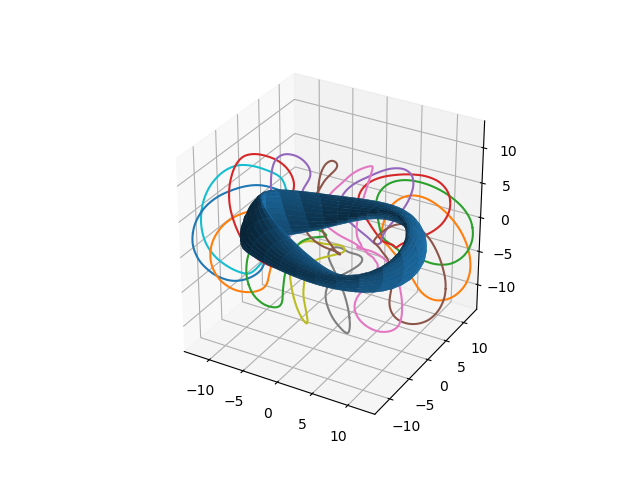

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, show=False, close=True)
for c in coils:
    c.plot(ax=ax, show=False)

ax.set_aspect('equal')

In [150]:
bs.save('wechsung_coils.json')

'{\n  "@module": "simsopt._core.json",\n  "@class": "SIMSON",\n  "@version": "0.19.0.post0+gc859dfb3.d20230815.dirty",\n  "graph": {\n    "$type": "ref",\n    "value": "BiotSavart38"\n  },\n  "simsopt_objs": {\n    "11193044800": {\n      "@module": "simsopt._core.optimizable",\n      "@class": "DOFs",\n      "@name": "11193044800",\n      "@version": "0.19.0.post0+gc859dfb3.d20230815.dirty",\n      "x": {\n        "@module": "numpy",\n        "@class": "array",\n        "dtype": "float64",\n        "data": [\n          11.906138072383674,\n          -0.3698872826075361,\n          5.214298854567364,\n          -0.11312009568021889,\n          0.723561797730379,\n          -0.003735207607762481,\n          -0.4399889163022786,\n          -0.013603600770931376,\n          0.052247507014307505,\n          -0.04138406334839013,\n          0.029613694221157998,\n          0.07934516497818789,\n          0.005644822470412036,\n          -0.05826747318347724,\n          -0.002832334529798386

In [154]:
for ii, c in enumerate(coils):
    print(ii)
    c.curve.unfix('xc(0)')

0
1
2
3
4


ValueError: 'xc(0)' is not in list

In [155]:
coils[4].dof_names

['Current657:x0',
 'CurveXYZFourier661:xc(0)',
 'CurveXYZFourier661:xs(1)',
 'CurveXYZFourier661:xc(1)',
 'CurveXYZFourier661:xs(2)',
 'CurveXYZFourier661:xc(2)',
 'CurveXYZFourier661:xs(3)',
 'CurveXYZFourier661:xc(3)',
 'CurveXYZFourier661:xs(4)',
 'CurveXYZFourier661:xc(4)',
 'CurveXYZFourier661:xs(5)',
 'CurveXYZFourier661:xc(5)',
 'CurveXYZFourier661:xs(6)',
 'CurveXYZFourier661:xc(6)',
 'CurveXYZFourier661:xs(7)',
 'CurveXYZFourier661:xc(7)',
 'CurveXYZFourier661:xs(8)',
 'CurveXYZFourier661:xc(8)',
 'CurveXYZFourier661:xs(9)',
 'CurveXYZFourier661:xc(9)',
 'CurveXYZFourier661:xs(10)',
 'CurveXYZFourier661:xc(10)',
 'CurveXYZFourier661:xs(11)',
 'CurveXYZFourier661:xc(11)',
 'CurveXYZFourier661:xs(12)',
 'CurveXYZFourier661:xc(12)',
 'CurveXYZFourier661:xs(13)',
 'CurveXYZFourier661:xc(13)',
 'CurveXYZFourier661:xs(14)',
 'CurveXYZFourier661:xc(14)',
 'CurveXYZFourier661:xs(15)',
 'CurveXYZFourier661:xc(15)',
 'CurveXYZFourier661:xs(16)',
 'CurveXYZFourier661:xc(16)',
 'CurveXYZF

In [156]:
fname

'output_well_False_lengthbound_18.0_kap_5.0_msc_5.0_dist_0.1_fil_0_ig_3_order_16_alstart_0_expquad.nc'

In [157]:
from simsopt.geo import CurveLength

In [164]:
L = [CurveLength( c.curve ) for c in coils[0:4]]

In [165]:
sum([ll.J() for ll in L])

Array(166.22514157, dtype=float64)

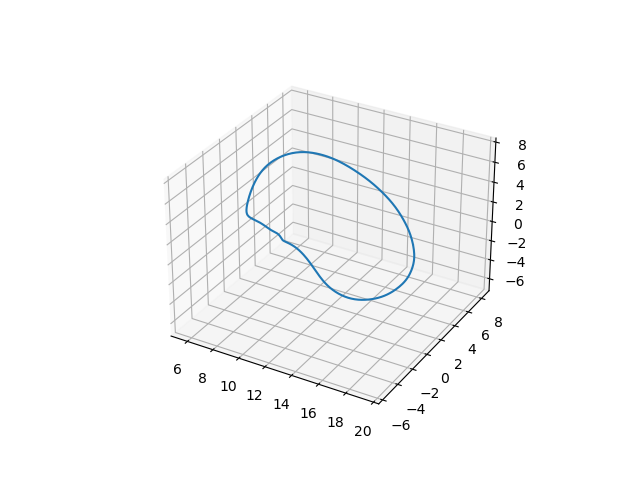

<Axes3D: >

In [160]:
coils[0].curve.plot()

In [166]:
18*9.229649839967937 /4

41.533424279855716